<a href="https://colab.research.google.com/github/wallisonferreira/machine-learning-pavic/blob/main/PAVIC_ML_06_Rede_Neural.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Sumário

# Imports and Configurações

In [1]:
import os
os.makedirs('utils_ex', exist_ok=True)
!wget -q https://github.com/mafaldasalomao/pavic_treinamento_ml/raw/main/utils/plot.py -O utils_ex/plot.py
!wget -q https://github.com/mafaldasalomao/pavic_treinamento_ml/raw/main/utils/samples_generator.py -O utils_ex/samples_generator.py

In [2]:
import numpy as np
import _pickle as pkl
import matplotlib.pyplot as plt
from sklearn.datasets import load_iris
from sklearn.datasets import make_blobs, make_circles, make_moons, make_classification

from sklearn.metrics import accuracy_score
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from utils_ex import plot
from utils_ex.samples_generator import make_spiral, make_square, make_cubic, make_exp, make_log10

%matplotlib inline

# Funções de Ativação

In [3]:
def linear(x, derivative=False):
    return np.ones_like(x) if derivative else x

def sigmoid(x, derivative=False):
    if derivative:
        y = sigmoid(x)
        return y*(1 - y)
    return 1.0/(1.0 + np.exp(-x))

def tanh(x, derivative=False):
    if derivative:
        y = tanh(x)
        return 1 - y**2
    return (np.exp(x) - np.exp(-x))/(np.exp(x) + np.exp(-x))

def relu(x, derivative=False):
    if derivative:
        return np.where(x <= 0, 0, 1)
    return np.maximum(0, x)

def leaky_relu(x, derivative=False):
    alpha = 0.1
    if derivative:
        return np.where(x <= 0, alpha, 1)
    return np.where(x <= 0, alpha*x, x)

def elu(x, derivative=False):
    alpha = 1.0
    if derivative:
        y = elu(x)
        return np.where(x <= 0, y + alpha, 1)
    return np.where(x <= 0, alpha*(np.exp(x) - 1), x)

# Funções Auxiliares

In [4]:
def softmax(x, y_oh=None, derivative=False):
    if derivative:
        y_pred = softmax(x)
        k = np.nonzero(y_pred * y_oh)
        pk = y_pred[k]
        y_pred[k] = pk * (1.0 - pk)
        return y_pred
    exp = np.exp(x)
    return exp / np.sum(exp, axis=1, keepdims=True)

# Funções de Custo

###### Para Regressão

In [5]:
#MAE
def mae(y, y_pred, derivative=False):
  if derivative:
    return np.where(y_pred > y, 1, -1) / y.shape[0]
  return np.mean(np.abs(y - y_pred))

In [6]:
#MSE
def mse(y, y_pred, derivative=False):
  if derivative:
    return - (y - y_pred) / y.shape[0]
  return 0.5 * np.mean((y - y_pred)**2)

###### Para Classificação Binária

In [7]:
#BCE and Sigmoid cross entropy
def binary_cross_entropy(y, y_pred, derivative=False):
  if derivative:
    return -(y - y_pred) / (y_pred * (1-y_pred) * y.shape[0])
  return -np.mean(y*np.log(y_pred) + (1 - y)*np.log(1-y_pred))


def sigmoid_cross_entropy(y, y_pred, derivative=False):
  y_sigmoid = sigmoid(y_pred)
  if derivative:
    return -(y - y_sigmoid) / y.shape[0]
  return -np.mean(y*np.log(y_sigmoid) + (1-y)*np.log(1-y_sigmoid))




###### Para Classificação Multiclasse

In [26]:
def neg_log_likelihood(y_oh, y_pred, derivative=False):
    k = np.nonzero(y_pred * y_oh)
    pk = y_pred[k]
    if derivative:
        y_pred[k] = (-1.0 / pk)
        return y_pred
    return np.mean(-np.log(pk))

def softmax_neg_log_likelihood(y_oh, y_pred, derivative=False):
    y_softmax = softmax(y_pred)
    if derivative:
        return -(y_oh - y_softmax) / y_oh.shape[0]
    return neg_log_likelihood(y_oh, y_softmax)

# Inicialização de Pesos

In [8]:
#Put your code here
def zeros(rows, cols): # in, out
  return np.zeros((rows, cols))

def ones(rows, cols):
  return np.ones((rows, cols))

def random_normal(rows, cols):
  return np.random.randn(rows, cols)

def random_uniform(rows, cols):
  return np.random.rand(rows, cols)

def glorot_normal(rows, cols):
  std_dev = np.sqrt(2.0 / (rows + cols))
  return std_dev * np.random.randn(rows, cols)

def glorot_uniform(rows, cols):
  limit = np.sqrt(6.0 / (rows +  cols))
  return 2 * limit * np.random.randn(rows, cols) - limit

# Regularização

In [ ]:
#Put Code Here

# Batch Generator

In [ ]:
#put code here

# Learning Rate Decay

In [ ]:
#Put code here

# Batch Normalization

In [ ]:
#Put code here

# Implementação

In [9]:
#PUT YOUR CODE HERE
class Layer():
  def __init__(self, input_dim, output_dim,
               weights_initializer=random_normal,
               bias_initializer=ones, activation=linear):
    self.input = None
    self.weights = weights_initializer(output_dim, input_dim)
    self.biases = bias_initializer(1, output_dim)
    self.activation = activation


    # salvar nossas saídas da rede
    self._activ_inp, self._activ_out = None, None
    # salvar nossas derivadas
    self._dweights, self._dbiases = None, None


class NeuralNetwork():
  def __init__(self, cost_func=mse, learning_rate=1e-3):
    self.layers = []
    self.cost_func = cost_func
    self.learning_rate = learning_rate

  def fit(self, x_train, y_train, epochs=100, verbose=10):
    for epoch in range(epochs + 1):
      #calcular nosso feed_forward
      y_pred = self.__feedforward(x_train)
      #caclulcar nosso backprop
      y_pred = self.__backprop(y_train, y_pred)

      if epoch % verbose == 0:
        loss_train = self.cost_func(y_train, self.predict(x_train))
        print("Epoch: {0:=4} / {1} loss_train: {2:.8f}".format(epoch, epochs, loss_train))




  def predict(self, x):
    return self.__feedforward(x)

  def __feedforward(self, x):
    self.layers[0].input = x

    for current_layer, next_layer in zip(self.layers, self.layers[1:] + [Layer(0,0)]):
      y = np.dot(current_layer.input, current_layer.weights.T) + current_layer.biases
      current_layer._activ_inp = y
      current_layer._activ_out = next_layer.input = current_layer.activation(y)


    return self.layers[-1]._activ_out

  def __backprop(self, y, y_pred):
    last_delta = self.cost_func(y, y_pred, derivative=True)
    #calcular a derivada para as camadas
    for layer in reversed(self.layers):
      dactivation = layer.activation(layer._activ_inp, derivative=True) * last_delta
      last_delta = np.dot(dactivation, layer.weights)
      layer._dweights = np.dot(dactivation.T, layer.input)
      layer._dbiases = 1.0 * dactivation.sum(axis=0, keepdims=True)

    for layer in reversed(self.layers):
      layer.weights = layer.weights - self.learning_rate * layer._dweights
      layer.biases = layer.biases - self.learning_rate * layer._dbiases








## Exemplos do Notebook da Intuição

### Exemplo 1

In [ ]:
x = np.array([[0.05, 0.10]])
y = np.array([[0.01, 0.99]])

w1 = np.array([[0.15, 0.20], [0.25, 0.30]])
b1 = np.array([[0.35]])
w2 = np.array([[0.40, 0.45], [0.50, 0.55]])
b2 = np.array([[0.60]])



input_dim, output_dim = x.shape[1], y.shape[1]
# insira sua rede aqui!
nn = NeuralNetwork(cost_func=mse, learning_rate=0.5)
nn.layers.append(Layer(input_dim, output_dim=2, activation=sigmoid))
nn.layers.append(Layer(2, output_dim = output_dim, activation=sigmoid))

nn.layers[0].weights = w1
nn.layers[0].biases = b1
nn.layers[1].weights = w2
nn.layers[1].biases = b2

nn.fit(x, y, epochs=0, verbose=1)

for layer in nn.layers:
  print(layer.weights)

Epoch:    0 / 0 loss_train: 0.14023572
[[0.14978072 0.19956143]
 [0.24975114 0.29950229]]
[[0.35891648 0.40866619]
 [0.51130127 0.56137012]]


In [ ]:



x = np.array([[0.05, 0.10]])
y = np.array([[0.01, 0.99]])

w1 = np.array([[0.15, 0.20], [0.25, 0.30]])
b1 = np.array([[0.35]])
w2 = np.array([[0.40, 0.45], [0.50, 0.55]])
b2 = np.array([[0.60]])

# insira sua rede aqui!


### Exemplo 2

In [ ]:
x = np.array([[0.1, 0.2, 0.7]])
y = np.array([[1, 0, 0]])
D_in, D_out = x.shape[1], y.shape[1]

w1 = np.array([[0.1, 0.2, 0.3], [0.3, 0.2, 0.7], [0.4, 0.3, 0.9]])
b1 = np.ones((1,3))
w2 = np.array([[0.2, 0.3, 0.5], [0.3, 0.5, 0.7], [0.6, 0.4, 0.8]])
b2 = np.ones((1,3))
w3 = np.array([[0.1, 0.4, 0.8], [0.3, 0.7, 0.2], [0.5, 0.2, 0.9]])
b3 = np.ones((1,3))

# insira sua rede aqui!
nn = NeuralNetwork(cost_func=softmax_neg_log_likelihood, learning_rate=0.01)
nn.layers.append(Layer(input_dim=D_in, output_dim=3, activation=relu))
nn.layers.append(Layer(input_dim=3, output_dim=3, activation=sigmoid))
nn.layers.append(Layer(input_dim=3, output_dim=D_out, activation=linear))

for i, w, b in zip(range(3), [w1, w2, w3], [b1, b2, b3]):
  nn.layers[i].weights = w
  nn.layers[i].biases = b

nn.fit(x, y, epochs=300, verbose=30)

for layer in nn.layers:
  print(layer.weights)



Epoch:    0 / 300 loss_train: 1.14054966
Epoch:   30 / 300 loss_train: 0.59630022
Epoch:   60 / 300 loss_train: 0.36031189
Epoch:   90 / 300 loss_train: 0.24668884
Epoch:  120 / 300 loss_train: 0.18386202
Epoch:  150 / 300 loss_train: 0.14510157
Epoch:  180 / 300 loss_train: 0.11918285
Epoch:  210 / 300 loss_train: 0.10078511
Epoch:  240 / 300 loss_train: 0.08712037
Epoch:  270 / 300 loss_train: 0.07660623
Epoch:  300 / 300 loss_train: 0.06828531
[[0.10083595 0.2016719  0.30585165]
 [0.30086971 0.20173942 0.70608796]
 [0.40145052 0.30290104 0.91015363]]
[[0.20544723 0.30673159 0.50749567]
 [0.30994562 0.5123005  0.71366784]
 [0.61065514 0.41317913 0.81464085]]
[[ 0.66465527  0.98758148  1.39393956]
 [ 0.05020341  0.44006253 -0.06274803]
 [ 0.18514132 -0.12764401  0.56880846]]


## Regressão

### Regressão Linear Simples - Exemplo do Perceptron

(100, 2)
(100, 1) (100, 1)


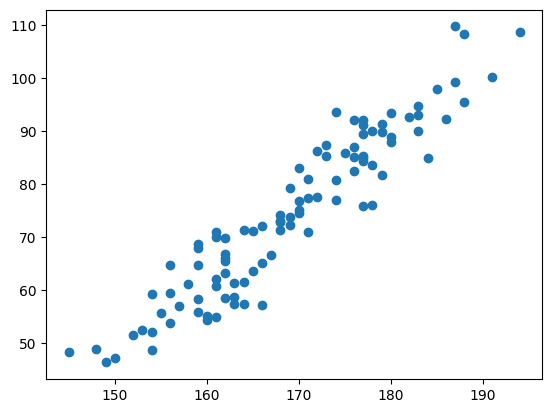

In [ ]:
data = np.loadtxt('medidas.csv', delimiter=',', skiprows=1)
print(data.shape)

x, y = data[:,0].reshape(-1,1), data[:,1].reshape(-1,1)
print(x.shape, y.shape)
plt.scatter(x, y)

-1.0 0.9999999999999991


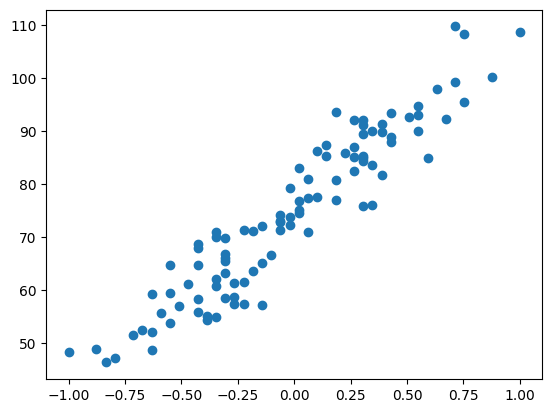

In [ ]:
minmax = MinMaxScaler(feature_range=(-1, 1))
x = minmax.fit_transform(x.astype(np.float64))

print(x.min(), x.max())
plt.scatter(x, y)

Epoch:    0 / 5000 loss_train: 2746.35519274
Epoch:  500 / 5000 loss_train: 30.17984630
Epoch: 1000 / 5000 loss_train: 15.66342373
Epoch: 1500 / 5000 loss_train: 13.44523829
Epoch: 2000 / 5000 loss_train: 13.10363936
Epoch: 2500 / 5000 loss_train: 13.05103326
Epoch: 3000 / 5000 loss_train: 13.04293194
Epoch: 3500 / 5000 loss_train: 13.04168434
Epoch: 4000 / 5000 loss_train: 13.04149222
Epoch: 4500 / 5000 loss_train: 13.04146263
Epoch: 5000 / 5000 loss_train: 13.04145807
Weights:  [[33.59866947]]
Bias:  [[74.99628662]]


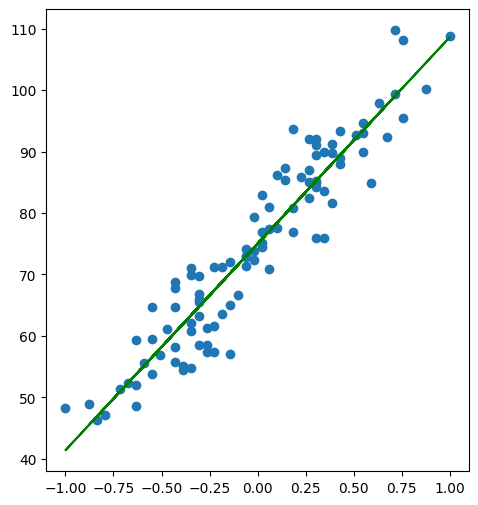

In [ ]:
input_dim, output_dim = x.shape[1], y.shape[1]

#build nn
nn = NeuralNetwork(cost_func=mse, learning_rate=1e-2)
nn.layers.append(Layer(input_dim=input_dim, output_dim=output_dim, activation=linear))

#train nn
nn.fit(x, y, epochs=5000, verbose=500)

#print w and b
print("Weights: ", nn.layers[0].weights)
print("Bias: ", nn.layers[0].biases)

#plot
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.scatter(x,y)
plt.plot(x, nn.predict(x), c='green')

### Regressão Linear Multivariada - Exercício de Regressão do Perceptron

In [ ]:
data = np.loadtxt('notas.csv', delimiter=',', skiprows=1)
print(data.shape)

x, y = data[:,:-1], data[:,-1].reshape(-1,1)
print(x.shape, y.shape)

(25, 4)
(25, 3) (25, 1)


In [ ]:
minmax = MinMaxScaler(feature_range=(-1, 1))
x = minmax.fit_transform(x.astype(np.float64))

print(x.min(axis=0), x.max(axis=0))
print(x.shape, y.shape)
#plt.scatter(x, y)

[-1. -1. -1.] [1. 1. 1.]
(25, 3) (25, 1)


In [ ]:
input_dim, output_dim = x.shape[1], y.shape[1]
#Build
nn=NeuralNetwork(cost_func=mse, learning_rate=1e-1)
nn.layers.append(Layer(input_dim=input_dim, output_dim=output_dim, activation=linear))
#train
nn.fit(x, y, epochs=3000, verbose=300)

print("Weights: ", nn.layers[0].weights)
print("Biases: ", nn.layers[0].biases)

Epoch:    0 / 3000 loss_train: 10042.56405633
Epoch:  300 / 3000 loss_train: 4.67893659
Epoch:  600 / 3000 loss_train: 3.17091619
Epoch:  900 / 3000 loss_train: 2.93299290
Epoch: 1200 / 3000 loss_train: 2.88510378
Epoch: 1500 / 3000 loss_train: 2.87338664
Epoch: 1800 / 3000 loss_train: 2.87019279
Epoch: 2100 / 3000 loss_train: 2.86927988
Epoch: 2400 / 3000 loss_train: 2.86901403
Epoch: 2700 / 3000 loss_train: 2.86893606
Epoch: 3000 / 3000 loss_train: 2.86891313
Weights:  [[ 8.74503008 14.08991863 26.25786803]]
Biases:  [[150.65035692]]


### Regressão Quadrática

(100, 1) (100, 1)


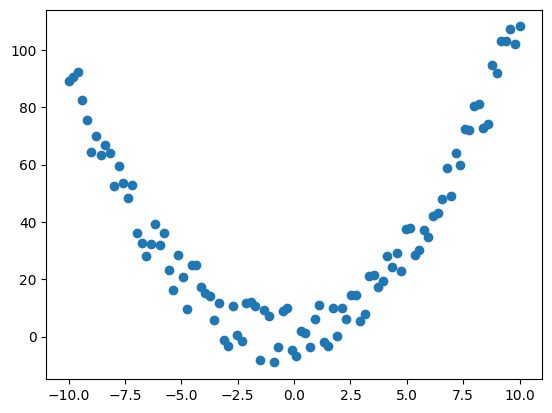

In [ ]:
x, y = make_square(n_samples=100, x_min=-10, x_max=10, a=1, b=1, c=1, noise=10)

print(x.shape, y.shape)
plt.scatter(x, y)

In [ ]:
minmax = MinMaxScaler(feature_range=(-1, 1))
x = minmax.fit_transform(x.astype(np.float64))
print(x.min(axis=0), x.max(axis=0))

[-1.] [1.]


Epoch:    0 / 5000 loss_train: 883.02276941
Epoch:  500 / 5000 loss_train: 501.19515476
Epoch: 1000 / 5000 loss_train: 24.66206642
Epoch: 1500 / 5000 loss_train: 19.30341359
Epoch: 2000 / 5000 loss_train: 17.34765106
Epoch: 2500 / 5000 loss_train: 16.75093903
Epoch: 3000 / 5000 loss_train: 16.56619430
Epoch: 3500 / 5000 loss_train: 16.47704465
Epoch: 4000 / 5000 loss_train: 16.41498134
Epoch: 4500 / 5000 loss_train: 16.36485014
Epoch: 5000 / 5000 loss_train: 16.32203132


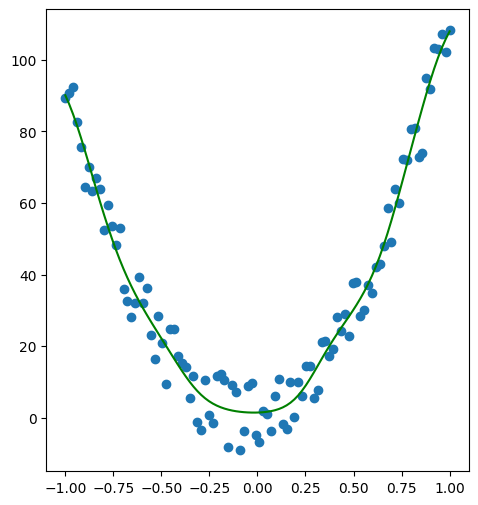

In [ ]:
input_dim, output_dim = x.shape[1], y.shape[1]

# insira sua rede aqui!
nn = NeuralNetwork(cost_func=mse, learning_rate=0.01)
nn.layers.append(Layer(input_dim=input_dim, output_dim=10, weights_initializer=random_uniform, bias_initializer=random_uniform, activation=sigmoid))
nn.layers.append(Layer(input_dim=10, output_dim=10, weights_initializer=random_uniform, bias_initializer=random_uniform, activation=sigmoid))
nn.layers.append(Layer(input_dim=10, output_dim=output_dim, weights_initializer=random_uniform, bias_initializer=random_uniform, activation=linear))

#train
nn.fit(x, y, epochs=5000, verbose=500)

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.scatter(x, y)
plt.plot(x, nn.predict(x), c='green')

### Regressão Cúbica

(100, 1) (100, 1)


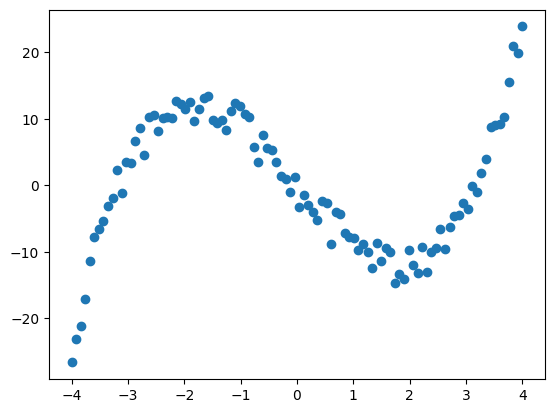

In [ ]:
x, y = make_cubic(n_samples=100, x_min=-4, x_max=4, a=1, b=0, c=-10, d=0, noise=3)

print(x.shape, y.shape)
plt.scatter(x, y)

In [ ]:
minmax = MinMaxScaler(feature_range=(-1, 1))
x = minmax.fit_transform(x.astype(np.float64))

print(x.min(axis=0), x.max(axis=0))

[-1.] [1.]


Epoch:    0 / 5000 loss_train: 59.46071191
Epoch:  500 / 5000 loss_train: 51.13419828
Epoch: 1000 / 5000 loss_train: 51.01493920
Epoch: 1500 / 5000 loss_train: 50.88744391
Epoch: 2000 / 5000 loss_train: 50.75806418
Epoch: 2500 / 5000 loss_train: 50.60792387
Epoch: 3000 / 5000 loss_train: 50.41945509
Epoch: 3500 / 5000 loss_train: 50.18175978
Epoch: 4000 / 5000 loss_train: 49.88830604
Epoch: 4500 / 5000 loss_train: 49.53693148
Epoch: 5000 / 5000 loss_train: 49.13035833


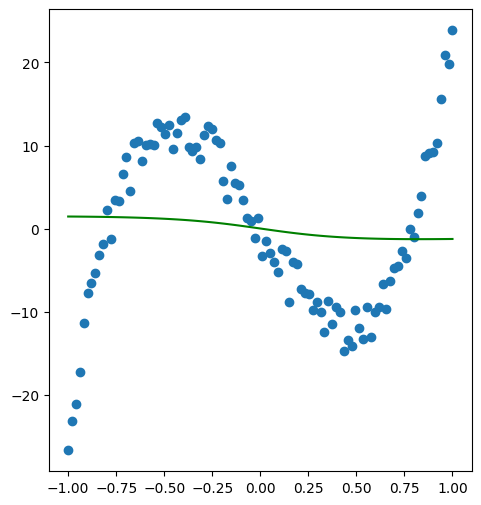

In [ ]:
input_dim, output_dim = x.shape[1], y.shape[1]
#build model
nn = NeuralNetwork(cost_func=mse, learning_rate=0.001)
nn.layers.append(Layer(input_dim=input_dim, output_dim=10, activation=sigmoid))
nn.layers.append(Layer(10, 10, activation=sigmoid))
nn.layers.append(Layer(10, output_dim, activation=linear))
#train
nn.fit(x, y, epochs=5000, verbose=500)


plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.scatter(x, y)
plt.plot(x, nn.predict(x), c='green')

### Regressão Logarítimica

(100, 1) (100, 1)


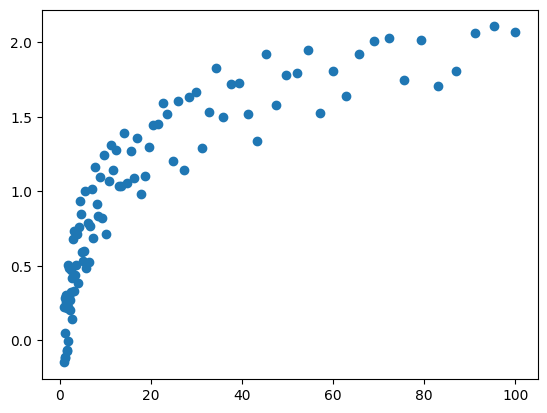

In [ ]:
x, y = make_log10(n_samples=100, x_min=1, x_max=100, noise=0.3)

print(x.shape, y.shape)
plt.scatter(x, y)

In [ ]:
minmax = MinMaxScaler(feature_range=(-1, 1))
x = minmax.fit_transform(x.astype(np.float64))

print(x.min(axis=0), x.max(axis=0))

[-1.] [1.]


Epoch:    0 / 5000 loss_train: 7.48851817
Epoch:  200 / 5000 loss_train: 0.03457449
Epoch:  400 / 5000 loss_train: 0.03057868
Epoch:  600 / 5000 loss_train: 0.02844062
Epoch:  800 / 5000 loss_train: 0.02698236
Epoch: 1000 / 5000 loss_train: 0.02589135
Epoch: 1200 / 5000 loss_train: 0.02502750
Epoch: 1400 / 5000 loss_train: 0.02431659
Epoch: 1600 / 5000 loss_train: 0.02371586
Epoch: 1800 / 5000 loss_train: 0.02319895
Epoch: 2000 / 5000 loss_train: 0.02274847
Epoch: 2200 / 5000 loss_train: 0.02235222
Epoch: 2400 / 5000 loss_train: 0.02200115
Epoch: 2600 / 5000 loss_train: 0.02168826
Epoch: 2800 / 5000 loss_train: 0.02140794
Epoch: 3000 / 5000 loss_train: 0.02115561
Epoch: 3200 / 5000 loss_train: 0.02092742
Epoch: 3400 / 5000 loss_train: 0.02072014
Epoch: 3600 / 5000 loss_train: 0.02053103
Epoch: 3800 / 5000 loss_train: 0.02035775
Epoch: 4000 / 5000 loss_train: 0.02019829
Epoch: 4200 / 5000 loss_train: 0.02005093
Epoch: 4400 / 5000 loss_train: 0.01991417
Epoch: 4600 / 5000 loss_train: 0.0

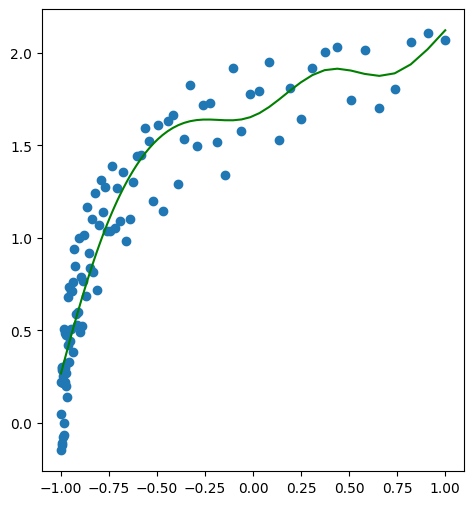

In [ ]:
input_dim, output_dim = x.shape[1], y.shape[1]

nn = NeuralNetwork(cost_func=mse, learning_rate=1e-2)
nn.layers.append(Layer(input_dim, 20, activation=tanh))
nn.layers.append(Layer(20, 20, activation=tanh))
nn.layers.append(Layer(20, output_dim, activation=linear))

#train
nn.fit(x, y, epochs=5000, verbose=200)

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.scatter(x, y)
plt.plot(x, nn.predict(x), c='green')

### Regressão Exponencial

(100, 1) (100, 1)


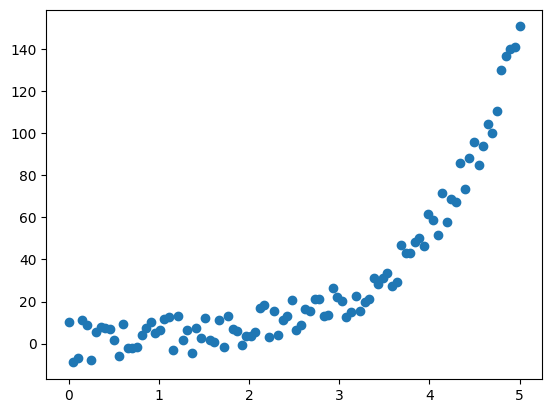

In [ ]:
x, y = make_exp(n_samples=100, x_min=0, x_max=5, noise=10)

print(x.shape, y.shape)
plt.scatter(x, y)

In [ ]:
minmax = MinMaxScaler(feature_range=(-1, 1))
x = minmax.fit_transform(x.astype(np.float64))

print(x.min(axis=0), x.max(axis=0))

[-1.] [1.]


Epoch:    0 / 5000 loss_train: 1023.46331662
Epoch:  200 / 5000 loss_train: 69.56698706
Epoch:  400 / 5000 loss_train: 41.42474975
Epoch:  600 / 5000 loss_train: 33.00953694
Epoch:  800 / 5000 loss_train: 29.51180408
Epoch: 1000 / 5000 loss_train: 29.50195533
Epoch: 1200 / 5000 loss_train: 29.94495058
Epoch: 1400 / 5000 loss_train: 23.96631471
Epoch: 1600 / 5000 loss_train: 20.54810493
Epoch: 1800 / 5000 loss_train: 21.15370179
Epoch: 2000 / 5000 loss_train: 21.32919289
Epoch: 2200 / 5000 loss_train: 20.86158574
Epoch: 2400 / 5000 loss_train: 20.62054615
Epoch: 2600 / 5000 loss_train: 20.18504984
Epoch: 2800 / 5000 loss_train: 19.73796317
Epoch: 3000 / 5000 loss_train: 19.31568105
Epoch: 3200 / 5000 loss_train: 18.89541176
Epoch: 3400 / 5000 loss_train: 18.52089137
Epoch: 3600 / 5000 loss_train: 19.19908935
Epoch: 3800 / 5000 loss_train: 17.81017805
Epoch: 4000 / 5000 loss_train: 17.46173940
Epoch: 4200 / 5000 loss_train: 17.28129777
Epoch: 4400 / 5000 loss_train: 17.13809825
Epoch: 46

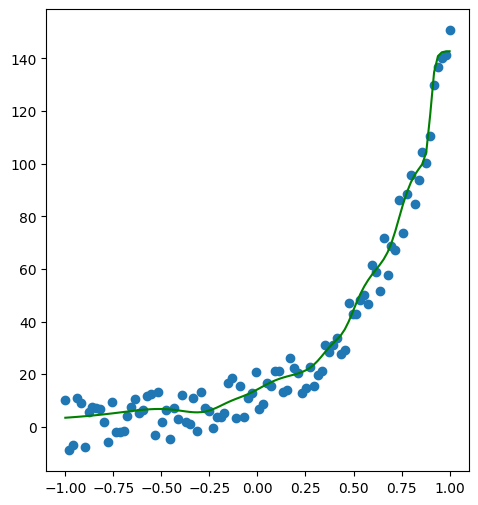

In [ ]:
input_dim, output_dim = x.shape[1], y.shape[1]
#build the model
nn = NeuralNetwork(cost_func=mse, learning_rate=1e-2)
nn.layers.append(Layer(input_dim, 16, activation=tanh))
nn.layers.append(Layer(16, 8, activation=tanh))
nn.layers.append(Layer(8, output_dim, activation=linear))
#train the model
nn.fit(x, y, epochs=5000, verbose=200)

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.scatter(x, y)
plt.plot(x, nn.predict(x), c='green')



## Classificação Binária

### Porta AND/OR

(4, 2) (4, 1)


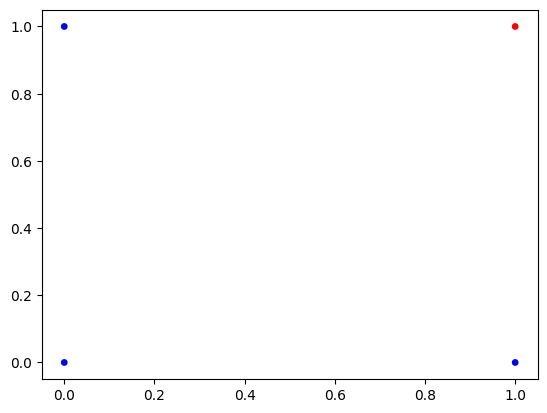

In [ ]:
x = np.array([[0, 0], [0, 1], [1, 0], [1, 1]])
y = np.array([0, 0, 0, 1]).reshape(-1, 1)

print(x.shape, y.shape)
plt.scatter(x[:,0], x[:,1], c=list(np.array(y).ravel()), s=15, cmap='bwr')

In [ ]:
input_dim, output_dim = x.shape[1], y.shape[1]

#BUILD MODEL
nn=NeuralNetwork(cost_func=binary_cross_entropy, learning_rate=1e-1)
nn.layers.append(Layer(input_dim=input_dim, output_dim=output_dim, activation=sigmoid))

#train model
nn.fit(x, y, epochs=2000, verbose=200)

y_pred = nn.predict(x)

print('Predictions: ', y_pred, sep='\n')
print('Accurace: {:.2f}%'.format(100*accuracy_score(y, y_pred > 0.5)))

#plot.classification_predictions(x, y, is_binary=True, nn=nn, cmap='bwr')
nn.layers[0].weights, nn.layers[0].biases

Epoch:    0 / 2000 loss_train: 1.45338224
Epoch:  200 / 2000 loss_train: 0.33444382
Epoch:  400 / 2000 loss_train: 0.24415338
Epoch:  600 / 2000 loss_train: 0.19435446
Epoch:  800 / 2000 loss_train: 0.16178229
Epoch: 1000 / 2000 loss_train: 0.13854251
Epoch: 1200 / 2000 loss_train: 0.12105440
Epoch: 1400 / 2000 loss_train: 0.10740082
Epoch: 1600 / 2000 loss_train: 0.09644408
Epoch: 1800 / 2000 loss_train: 0.08746011
Epoch: 2000 / 2000 loss_train: 0.07996392
Predictions: 
[[0.0013414 ]
 [0.08845044]
 [0.08859211]
 [0.87534312]]
Accurace: 100.00%


(array([[4.28175448, 4.27999871]]), array([[-6.61270227]]))

### Porta XOR

(4, 2) (4, 1)


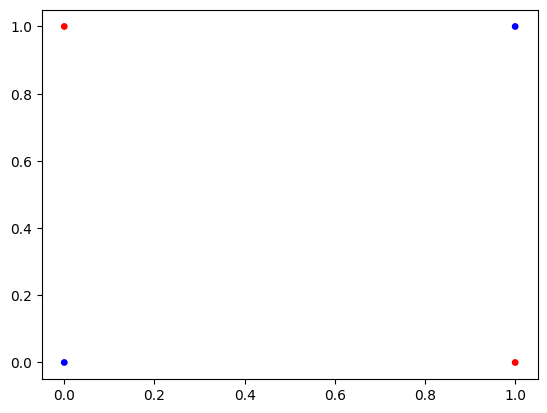

In [ ]:
x = np.array([[0, 0], [0, 1], [1, 0], [1, 1]])
y = np.array([0, 1, 1, 0]).reshape(-1, 1)

print(x.shape, y.shape)
plt.scatter(x[:,0], x[:,1], c=list(np.array(y).ravel()), s=15, cmap='bwr')

In [ ]:
input_dim, output_dim = x.shape[1], y.shape[1]

# Build model
nn = NeuralNetwork(cost_func=binary_cross_entropy, learning_rate=1)
nn.layers.append(Layer(input_dim=input_dim, output_dim=2, activation=sigmoid))
nn.layers.append(Layer(2, output_dim=output_dim, activation=sigmoid))

#Fit
nn.fit(x, y, epochs=3000, verbose=500)

y_pred=nn.predict(x)

print("Predictions: ", y_pred, sep='\n')
print("Acc: {:.2f}%".format(100*accuracy_score(y, y_pred > 0.5)))


Epoch:    0 / 3000 loss_train: 0.76803315
Epoch:  500 / 3000 loss_train: 0.05126427
Epoch: 1000 / 3000 loss_train: 0.01433544
Epoch: 1500 / 3000 loss_train: 0.00819512
Epoch: 2000 / 3000 loss_train: 0.00571441
Epoch: 2500 / 3000 loss_train: 0.00437922
Epoch: 3000 / 3000 loss_train: 0.00354668
Predictions: 
[[0.00340204]
 [0.99536402]
 [0.99682344]
 [0.00294617]]
Acc: 100.00%


In [ ]:
y, y_pred > 0.5

(array([[0],
        [1],
        [1],
        [0]]),
 array([[False],
        [ True],
        [ True],
        [False]]))

### 2 Clusters

(100, 2) (100, 1)


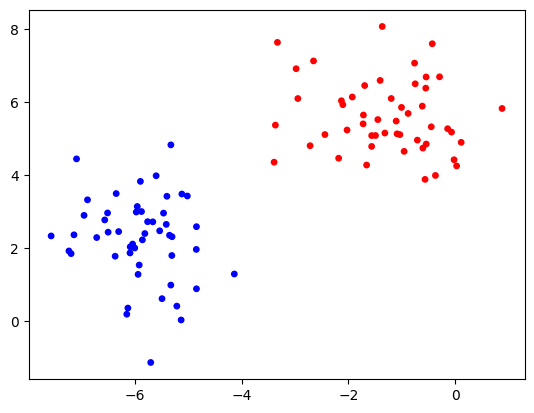

In [ ]:
x, y = make_blobs(n_samples=100, n_features=2, centers=2, random_state=1234)
y = y.reshape(-1, 1)

print(x.shape, y.shape)
plt.scatter(x[:,0], x[:,1], c=list(np.array(y).ravel()), s=15, cmap='bwr')

Epoch:    0 / 5000 loss_train: 7.86108982
Epoch:  500 / 5000 loss_train: 3.88884983
Epoch: 1000 / 5000 loss_train: 0.94752938
Epoch: 1500 / 5000 loss_train: 0.29758143
Epoch: 2000 / 5000 loss_train: 0.17059940
Epoch: 2500 / 5000 loss_train: 0.12159918
Epoch: 3000 / 5000 loss_train: 0.09574116
Epoch: 3500 / 5000 loss_train: 0.07971002
Epoch: 4000 / 5000 loss_train: 0.06875684
Epoch: 4500 / 5000 loss_train: 0.06077204
Epoch: 5000 / 5000 loss_train: 0.05467570
Acc: 100.00%


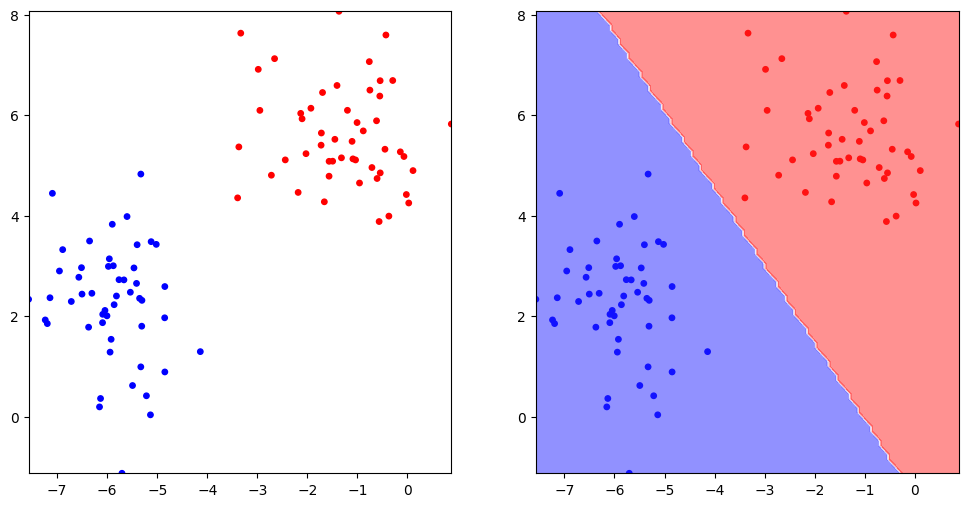

In [ ]:
input_dim, output_dim = x.shape[1], y.shape[1]

#build
nn=NeuralNetwork(cost_func=binary_cross_entropy, learning_rate=1e-3)
nn.layers.append(Layer(input_dim, output_dim, activation=sigmoid))

#train
nn.fit(x, y, epochs=5000, verbose=500)
y_pred = nn.predict(x)


threshold = 0 if nn.layers[-1].activation == linear else 0.5

print("Acc: {:.2f}%".format(100*accuracy_score(y, y_pred >= threshold)))
plot.classification_predictions(x, y, is_binary=True, nn=nn, threshold=threshold, cmap='bwr')

### 4 Clusters

(500, 2) (500, 1)


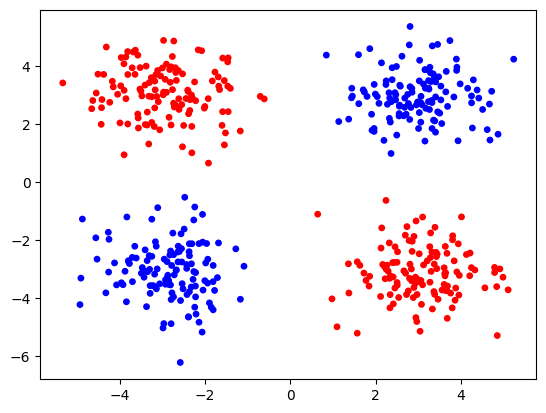

In [ ]:
x, y = make_blobs(n_samples=500, n_features=2, cluster_std=0.9, centers=[(-3, -3), (3, 3), (-3, 3), (3, -3)], random_state=1234)
y = y.reshape(-1, 1)
y = np.where(y >= 2, 1, 0)

print(x.shape, y.shape)
plt.scatter(x[:,0], x[:,1], c=list(np.array(y).ravel()), s=15, cmap='bwr')

Epoch:    0 / 3000 loss_train: 1.23034058
Epoch:  300 / 3000 loss_train: 0.01015765
Epoch:  600 / 3000 loss_train: 0.00492038
Epoch:  900 / 3000 loss_train: 0.00295615
Epoch: 1200 / 3000 loss_train: 0.00209304
Epoch: 1500 / 3000 loss_train: 0.00160471
Epoch: 1800 / 3000 loss_train: 0.00128449
Epoch: 2100 / 3000 loss_train: 0.00105776
Epoch: 2400 / 3000 loss_train: 0.00090032
Epoch: 2700 / 3000 loss_train: 0.00078302
Epoch: 3000 / 3000 loss_train: 0.00069227
Acc: 100.00%


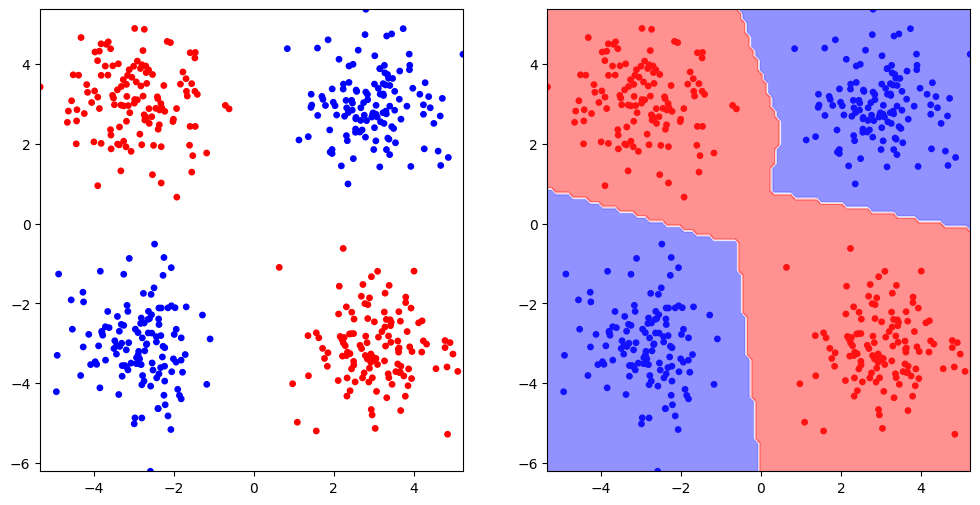

In [ ]:
input_dim, output_dim = x.shape[1], y.shape[1]


nn = NeuralNetwork(cost_func=binary_cross_entropy, learning_rate=1e-1)
nn.layers.append(Layer(input_dim, 4, activation=relu))
nn.layers.append(Layer(4, 4, activation=relu))
nn.layers.append(Layer(4, output_dim, activation=sigmoid))

nn.fit(x, y, epochs=3000, verbose=300)

y_pred = nn.predict(x)


print("Acc: {:.2f}%".format(100*accuracy_score(y, y_pred >= 0.5)))
plot.classification_predictions(x, y, is_binary=True, nn=nn, threshold=0.5, cmap='bwr')

### Círculos

(1000, 2) (1000, 1)


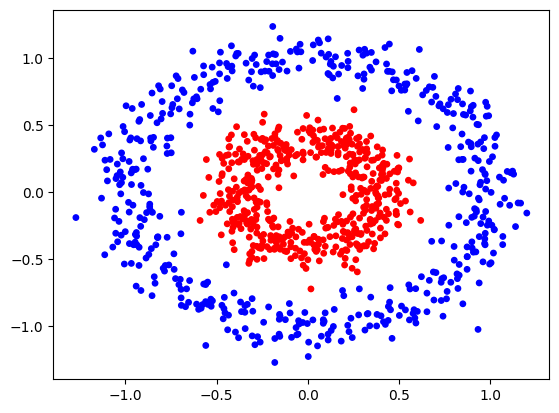

In [ ]:
x, y = make_circles(n_samples=1000, noise=0.1, factor=0.4, random_state=1234)
y = y.reshape(-1, 1)

print(x.shape, y.shape)
plt.scatter(x[:,0], x[:,1], c=list(np.array(y).ravel()), s=15, cmap='bwr')

Epoch:    0 / 5000 loss_train: 1.18557512
Epoch:  300 / 5000 loss_train: 0.54015648
Epoch:  600 / 5000 loss_train: 0.32630834
Epoch:  900 / 5000 loss_train: 0.20441382
Epoch: 1200 / 5000 loss_train: 0.14783842
Epoch: 1500 / 5000 loss_train: 0.11780649
Epoch: 1800 / 5000 loss_train: 0.09967442
Epoch: 2100 / 5000 loss_train: 0.08767667
Epoch: 2400 / 5000 loss_train: 0.07918591
Epoch: 2700 / 5000 loss_train: 0.07286216
Epoch: 3000 / 5000 loss_train: 0.06796036
Epoch: 3300 / 5000 loss_train: 0.06403716
Epoch: 3600 / 5000 loss_train: 0.06081394
Epoch: 3900 / 5000 loss_train: 0.05810764
Epoch: 4200 / 5000 loss_train: 0.05579342
Epoch: 4500 / 5000 loss_train: 0.05378339
Epoch: 4800 / 5000 loss_train: 0.05201396
Acc: 99.00%


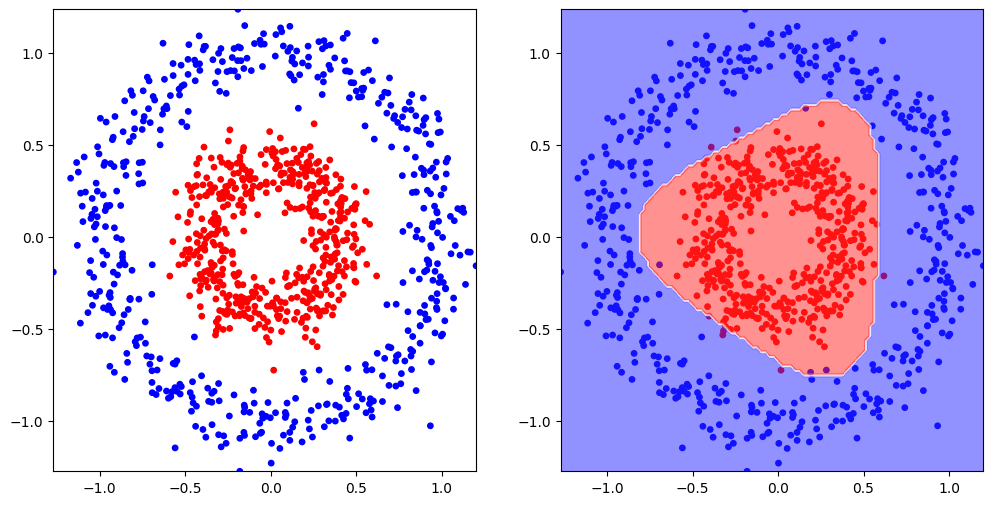

In [ ]:
input_dim, output_dim = x.shape[1], y.shape[1]

nn = NeuralNetwork(cost_func=binary_cross_entropy, learning_rate=0.1)
nn.layers.append(Layer(input_dim, 4, activation=tanh))
nn.layers.append(Layer(4, output_dim, activation=sigmoid))

nn.fit(x, y, epochs=5000, verbose=300)

y_pred = nn.predict(x)


print("Acc: {:.2f}%".format(100*accuracy_score(y, y_pred >= 0.5)))
plot.classification_predictions(x, y, is_binary=True, nn=nn, threshold=0.5, cmap='bwr')


### Moons

(200, 2) (200, 1)


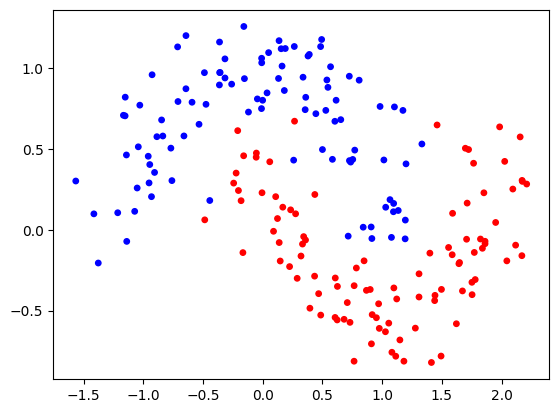

In [ ]:
x, y = make_moons(200, noise=0.20)
y = y.reshape(-1, 1)

print(x.shape, y.shape)
plt.scatter(x[:,0], x[:,1], c=list(np.array(y).ravel()), s=15, cmap='bwr')

Epoch:    0 / 8000 loss_train: 2.24461950
Epoch:  300 / 8000 loss_train: 0.13970305
Epoch:  600 / 8000 loss_train: 0.08599585
Epoch:  900 / 8000 loss_train: 0.06722515
Epoch: 1200 / 8000 loss_train: 0.05786400
Epoch: 1500 / 8000 loss_train: 0.05199823
Epoch: 1800 / 8000 loss_train: 0.04792119
Epoch: 2100 / 8000 loss_train: 0.04456354
Epoch: 2400 / 8000 loss_train: 0.04203340
Epoch: 2700 / 8000 loss_train: 0.03990007
Epoch: 3000 / 8000 loss_train: 0.03812568
Epoch: 3300 / 8000 loss_train: 0.03657869
Epoch: 3600 / 8000 loss_train: 0.03523944
Epoch: 3900 / 8000 loss_train: 0.03405964
Epoch: 4200 / 8000 loss_train: 0.03307246
Epoch: 4500 / 8000 loss_train: 0.03213298
Epoch: 4800 / 8000 loss_train: 0.03126302
Epoch: 5100 / 8000 loss_train: 0.03041766
Epoch: 5400 / 8000 loss_train: 0.02966550
Epoch: 5700 / 8000 loss_train: 0.02889447
Epoch: 6000 / 8000 loss_train: 0.02822199
Epoch: 6300 / 8000 loss_train: 0.02747239
Epoch: 6600 / 8000 loss_train: 0.02680525
Epoch: 6900 / 8000 loss_train: 0.0

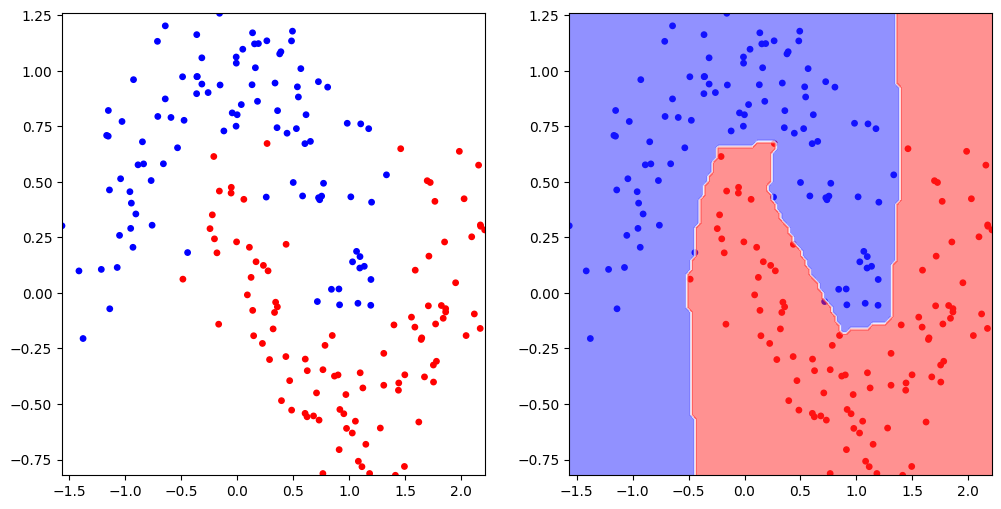

In [ ]:
input_dim, output_dim = x.shape[1], y.shape[1]


nn = NeuralNetwork(cost_func=binary_cross_entropy, learning_rate=0.1)
nn.layers.append(Layer(input_dim, 12, activation=relu))
nn.layers.append(Layer(12, 12, activation=relu))
nn.layers.append(Layer(12, output_dim, activation=sigmoid))

nn.fit(x, y, epochs=8000, verbose=300)

y_pred = nn.predict(x)


print("Acc: {:.2f}%".format(100*accuracy_score(y, y_pred >= 0.5)))
plot.classification_predictions(x, y, is_binary=True, nn=nn, threshold=0.5, cmap='bwr')


### Espiral

(200, 2) (200, 1)


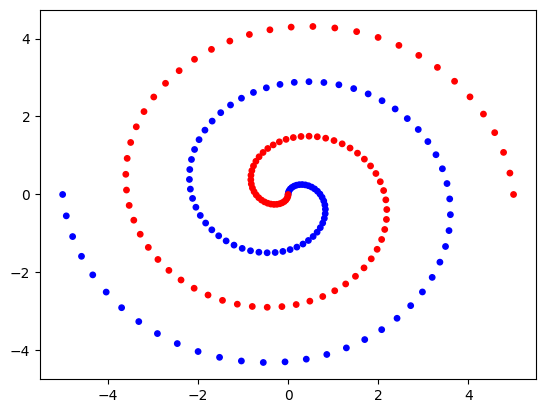

In [10]:
x, y = make_spiral(n_samples=100, n_class=2, radius=5, laps=1.75)
y = y.reshape(-1, 1)

print(x.shape, y.shape)
plt.scatter(x[:,0], x[:,1], c=list(np.array(y).ravel()), s=15, cmap='bwr')

Epoch:    0 / 10000 loss_train: 1.17730100
Epoch: 1000 / 10000 loss_train: 0.09746415
Epoch: 2000 / 10000 loss_train: 0.03354974
Epoch: 3000 / 10000 loss_train: 0.02173324
Epoch: 4000 / 10000 loss_train: 0.01706019
Epoch: 5000 / 10000 loss_train: 0.01456940
Epoch: 6000 / 10000 loss_train: 0.01303531
Epoch: 7000 / 10000 loss_train: 0.01199841
Epoch: 8000 / 10000 loss_train: 0.01125256
Epoch: 9000 / 10000 loss_train: 0.01069124
Epoch: 10000 / 10000 loss_train: 0.01025396
ACC: 99.00%


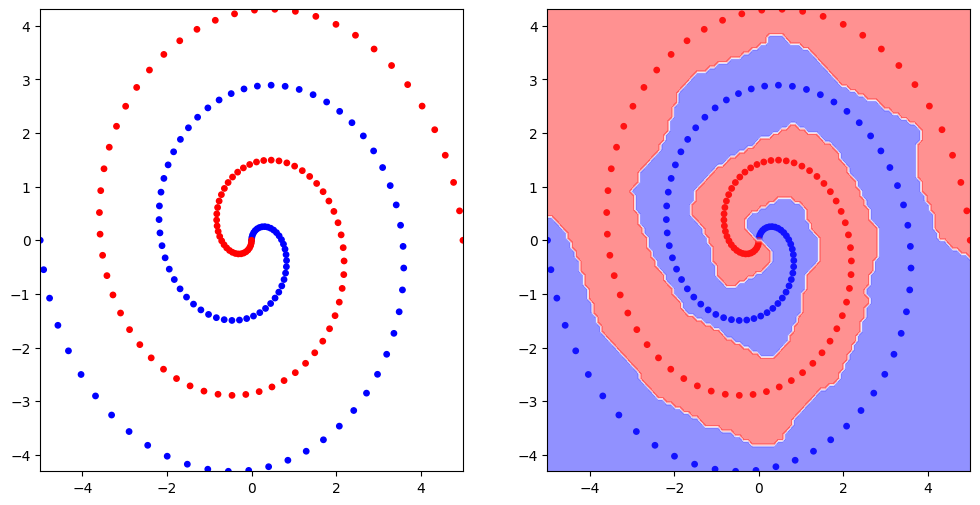

In [16]:
input_dim, output_dim = x.shape[1], y.shape[1]

# insira sua rede aqui!
nn = NeuralNetwork(cost_func=binary_cross_entropy, learning_rate=1e-1)
nn.layers.append(Layer(input_dim=input_dim, output_dim=20, activation=tanh))
nn.layers.append(Layer(20, 20, activation=tanh))
nn.layers.append(Layer(20, output_dim, activation=sigmoid))

nn.fit(x, y, epochs=10000, verbose=1000)
y_pred=nn.predict(x)

print('ACC: {:.2f}%'.format(100*accuracy_score(y, y_pred > 0.05)))

plot.classification_predictions(x, y, is_binary=True, nn=nn, threshold=0.5, cmap='bwr')


## Classificação Multiclasse

### 3 Clusters Multiclasse

(300, 2) (300, 1)


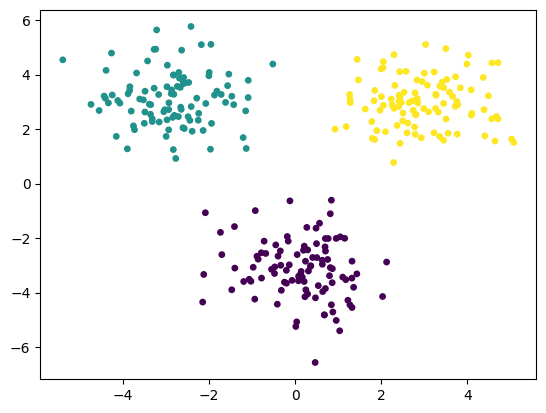

In [21]:
x, y = make_blobs(n_samples=300, n_features=2, centers=[(0, -3), (-3, 3), (3, 3)], random_state=1234)
y = y.reshape(-1, 1)

print(x.shape, y.shape)
plt.scatter(x[:,0], x[:,1], c=list(np.array(y).ravel()), s=15, cmap=plt.cm.viridis)

In [23]:
onehot = OneHotEncoder(sparse=False)
y_onehot = onehot.fit_transform(y)
print(y_onehot[::60])

[[0. 1. 0.]
 [1. 0. 0.]
 [0. 0. 1.]
 [0. 1. 0.]
 [1. 0. 0.]]


/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [30]:
y_pred

array([1, 2, 0, 2, 2, 2, 0, 0, 0, 0, 0, 2, 2, 0, 0, 2, 1, 1, 2, 0, 0, 2,
       0, 1, 2, 1, 1, 0, 1, 2, 0, 2, 1, 2, 2, 0, 0, 0, 1, 2, 1, 0, 0, 0,
       0, 2, 0, 1, 0, 2, 2, 2, 0, 1, 0, 1, 2, 1, 2, 2, 0, 2, 0, 0, 1, 0,
       0, 0, 2, 2, 0, 1, 0, 1, 0, 1, 0, 2, 2, 2, 1, 1, 1, 2, 2, 0, 2, 2,
       2, 0, 0, 0, 2, 1, 0, 2, 2, 2, 2, 2, 1, 0, 2, 1, 1, 1, 1, 1, 2, 2,
       2, 2, 2, 1, 1, 1, 2, 1, 2, 1, 2, 0, 0, 0, 0, 2, 0, 0, 2, 2, 1, 1,
       2, 2, 1, 2, 1, 1, 0, 2, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 2, 0, 0, 1,
       1, 1, 2, 1, 1, 1, 0, 1, 0, 2, 2, 1, 1, 0, 1, 2, 1, 0, 2, 0, 2, 2,
       0, 0, 2, 2, 1, 2, 2, 1, 1, 2, 1, 1, 0, 0, 1, 2, 0, 2, 2, 2, 0, 2,
       1, 2, 1, 0, 1, 1, 2, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 2, 1, 0, 2, 2,
       1, 2, 2, 0, 1, 1, 1, 0, 0, 0, 1, 2, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1,
       0, 0, 0, 1, 1, 0, 2, 2, 1, 2, 2, 0, 0, 2, 0, 1, 2, 1, 0, 0, 2, 2,
       2, 2, 1, 1, 1, 1, 2, 1, 1, 2, 0, 1, 1, 1, 0, 0, 0, 2, 0, 2, 1, 0,
       0, 0, 0, 0, 0, 0, 2, 2, 1, 1, 2, 2, 2, 0])

Epoch:    0 / 1000 loss_train: 2.12257013
Epoch:  100 / 1000 loss_train: 0.08089007
Epoch:  200 / 1000 loss_train: 0.04110017
Epoch:  300 / 1000 loss_train: 0.02720722
Epoch:  400 / 1000 loss_train: 0.02049227
Epoch:  500 / 1000 loss_train: 0.01664687
Epoch:  600 / 1000 loss_train: 0.01411283
Epoch:  700 / 1000 loss_train: 0.01230106
Epoch:  800 / 1000 loss_train: 0.01093484
Epoch:  900 / 1000 loss_train: 0.00986463
Epoch: 1000 / 1000 loss_train: 0.00900138
ACC: 100.00%


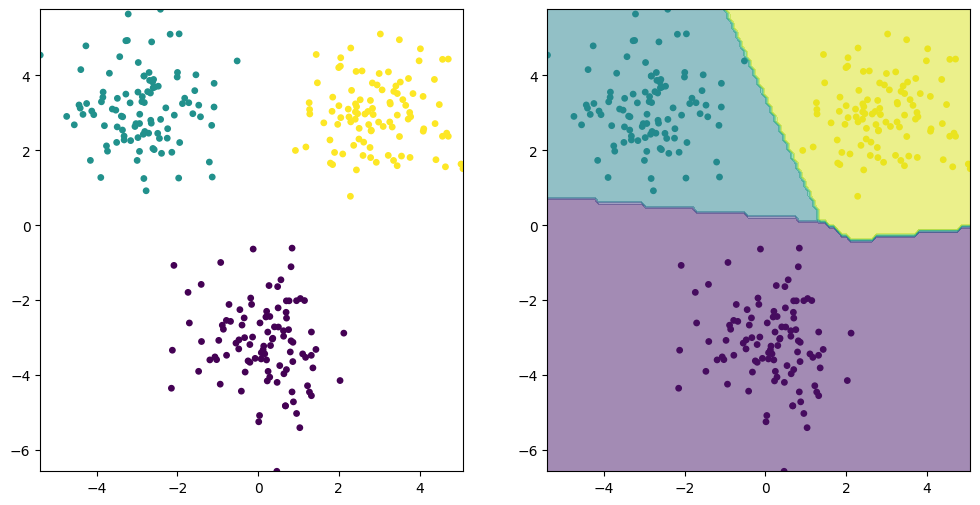

In [29]:
input_dim, output_dim = x.shape[1], y_onehot.shape[1]

# Build
model = NeuralNetwork(cost_func=softmax_neg_log_likelihood, learning_rate=1e-1)
model.layers.append(Layer(input_dim=input_dim, output_dim=2, activation=relu))
model.layers.append(Layer(input_dim=2, output_dim=output_dim, activation=linear))

# Fit
model.fit(x, y_onehot, epochs=1000, verbose=100)

y_pred = np.argmax(model.predict(x), axis=1) #[0.1, 0.2, 0.7]

print('ACC: {:.2f}%'.format(100*accuracy_score(y, y_pred)))

plot.classification_predictions(x, y, is_binary=False, nn=model)

### 4 Clusters Multiclasse

(400, 2) (400, 1)


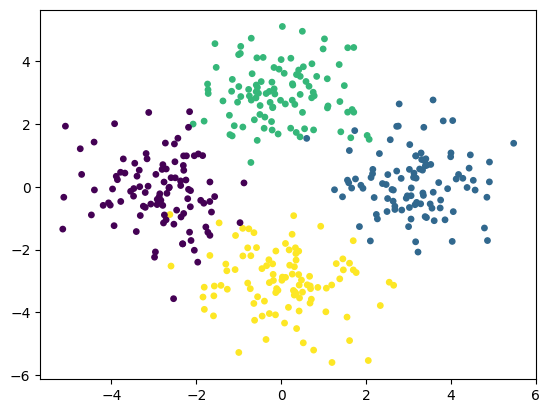

In [32]:
x, y = make_blobs(n_samples=400, n_features=2, centers=[(-3, 0), (3, 0), (0, 3), (0, -3)], random_state=1234)
y = y.reshape(-1, 1)

print(x.shape, y.shape)
plt.scatter(x[:,0], x[:,1], c=list(np.array(y).ravel()), s=15, cmap=plt.cm.viridis);

In [33]:
onehot = OneHotEncoder(sparse=False)
y_onehot = onehot.fit_transform(y)
print(y_onehot[::70])

[[0. 0. 1. 0.]
 [1. 0. 0. 0.]
 [0. 0. 1. 0.]
 [1. 0. 0. 0.]
 [0. 0. 0. 1.]
 [1. 0. 0. 0.]]


/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [39]:
nn.predict(x)[:10]

array([[ 2.08319515,  1.95906043,  3.66634501,  0.43686231],
       [-0.79544093,  8.3407546 ,  2.6959293 ,  2.29382806],
       [ 2.11478257,  2.41123935,  4.18162383,  0.32366909],
       [ 1.1068241 ,  0.16549558, -0.48768399,  1.77021577],
       [ 2.21013808,  3.77626857,  5.73713784, -0.01803647],
       [ 1.55479467, -0.00885132,  0.45454124,  1.33570932],
       [ 1.93537759, -0.15697144,  1.2550287 ,  0.96656514],
       [-1.54106261,  1.19603393, -6.05703568,  4.33851802],
       [-0.56240379,  7.76327714,  2.71568269,  2.15431535],
       [-0.98355117,  5.59190842, -0.42680575,  2.97787599]])

In [42]:
np.argmax(nn.predict(x)[:10])

5

Epoch:    0 / 1000 loss_train: 4.75701154
Epoch:  100 / 1000 loss_train: 1.18920939
Epoch:  200 / 1000 loss_train: 0.99067329
Epoch:  300 / 1000 loss_train: 0.83708055
Epoch:  400 / 1000 loss_train: 0.69800265
Epoch:  500 / 1000 loss_train: 0.58755132
Epoch:  600 / 1000 loss_train: 0.50467169
Epoch:  700 / 1000 loss_train: 0.44227915
Epoch:  800 / 1000 loss_train: 0.39373964
Epoch:  900 / 1000 loss_train: 0.35485772
Epoch: 1000 / 1000 loss_train: 0.32310355
ACC: 96.50%


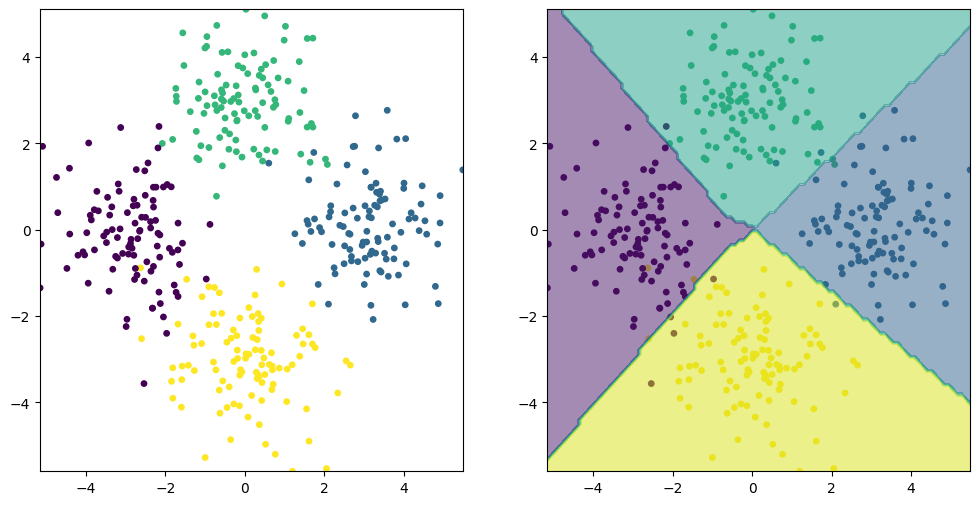

In [35]:
input_dim, output_dim = x.shape[1], y_onehot.shape[1]

# insira sua rede aqui!
nn = NeuralNetwork(cost_func=softmax_neg_log_likelihood, learning_rate=1e-2)

nn.layers.append(Layer(input_dim, 2, activation=relu))
nn.layers.append(Layer(2, output_dim, activation=linear))

nn.fit(x, y_onehot, epochs=1000, verbose=100)

y_pred = np.argmax(nn.predict(x), axis=1)

print('ACC: {:.2f}%'.format(100*accuracy_score(y, y_pred)))
plot.classification_predictions(x, y, is_binary=False, nn=nn)

### Espiral - 5 Classes

(500, 2) (500, 1)


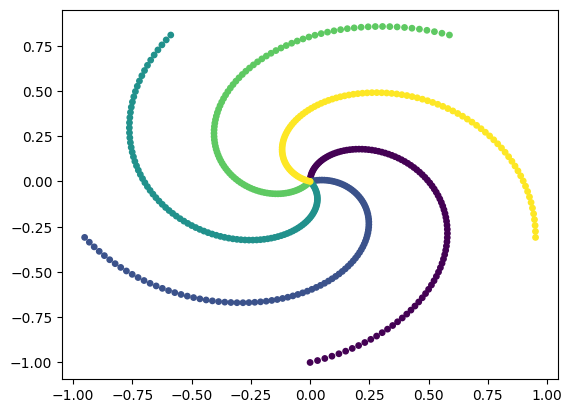

In [43]:
x, y = make_spiral(n_samples=100, n_class=5, radius=1, laps=0.5)
y = y.reshape(-1, 1)

print(x.shape, y.shape)
plt.scatter(x[:,0], x[:,1], c=list(np.array(y).ravel()), s=15, cmap=plt.cm.viridis)

In [44]:
onehot = OneHotEncoder(sparse=False)
y_onehot = onehot.fit_transform(y)
print(y_onehot[::100])

[[1. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0.]
 [0. 0. 1. 0. 0.]
 [0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 1.]]


/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Epoch:    0 / 3000 loss_train: 12.98213666
Epoch:  100 / 3000 loss_train: 0.36989786
Epoch:  200 / 3000 loss_train: 0.27633176
Epoch:  300 / 3000 loss_train: 0.22455913
Epoch:  400 / 3000 loss_train: 0.19023907
Epoch:  500 / 3000 loss_train: 0.16550366
Epoch:  600 / 3000 loss_train: 0.14683159
Epoch:  700 / 3000 loss_train: 0.13194633
Epoch:  800 / 3000 loss_train: 0.12028845
Epoch:  900 / 3000 loss_train: 0.11096602
Epoch: 1000 / 3000 loss_train: 0.10289357
Epoch: 1100 / 3000 loss_train: 0.09608924
Epoch: 1200 / 3000 loss_train: 0.09027569
Epoch: 1300 / 3000 loss_train: 0.08530673
Epoch: 1400 / 3000 loss_train: 0.08103454
Epoch: 1500 / 3000 loss_train: 0.07728136
Epoch: 1600 / 3000 loss_train: 0.07397550
Epoch: 1700 / 3000 loss_train: 0.07100818
Epoch: 1800 / 3000 loss_train: 0.06837857
Epoch: 1900 / 3000 loss_train: 0.06600700
Epoch: 2000 / 3000 loss_train: 0.06384954
Epoch: 2100 / 3000 loss_train: 0.06188610
Epoch: 2200 / 3000 loss_train: 0.06009351
Epoch: 2300 / 3000 loss_train: 0.

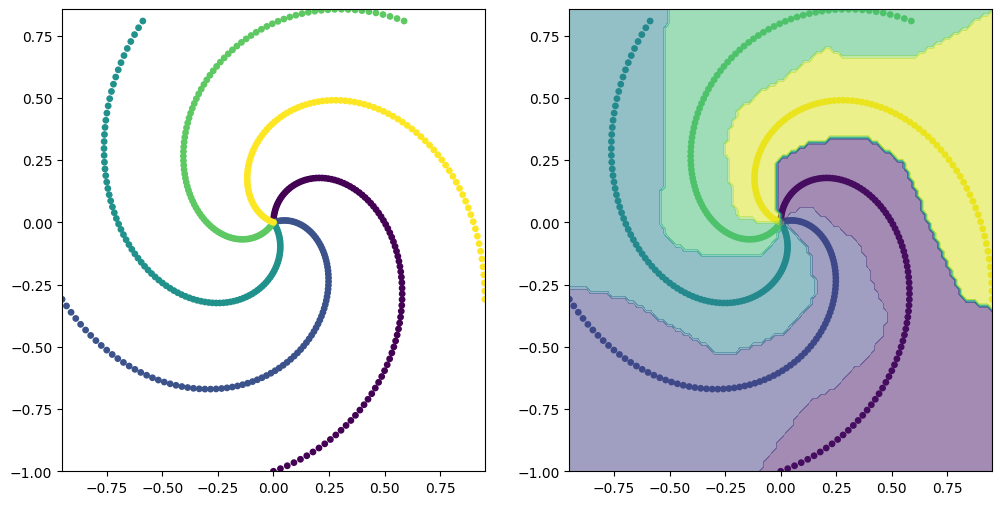

In [48]:
input_dim, output_dim = x.shape[1], y_onehot.shape[1]

# insira sua rede aqui!
nn = NeuralNetwork(cost_func=softmax_neg_log_likelihood, learning_rate=1e-1)
nn.layers.append(Layer(input_dim=input_dim, output_dim=20, activation=relu))
nn.layers.append(Layer(input_dim=20, output_dim=20, activation=relu))
nn.layers.append(Layer(input_dim=20, output_dim=output_dim, activation=linear))

nn.fit(x, y_onehot, epochs=3000, verbose=100)

y_pred = np.argmax(nn.predict(x), axis=1)

print('ACC: {:.2f}%'.format(100*accuracy_score(y, y_pred)))
plot.classification_predictions(x, y, is_binary=False, nn=nn)

### Make Classification - 4 Classes

(100, 2) (100, 1)


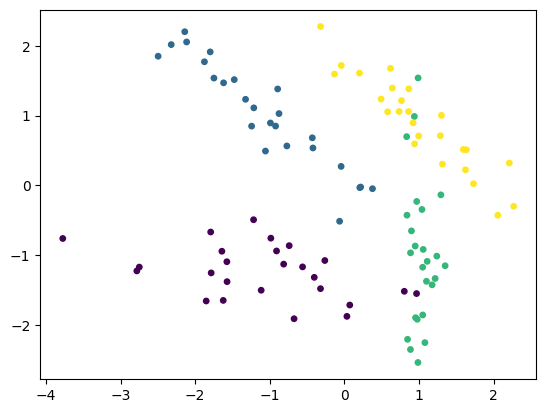

In [49]:
x, y = make_classification(n_samples=100, n_classes=4, n_features=2, n_clusters_per_class=1, n_redundant=0, n_repeated=0, random_state=1234)
y = y.reshape(-1, 1)

print(x.shape, y.shape)
plt.scatter(x[:,0], x[:,1], c=list(np.array(y).ravel()), s=15, cmap=plt.cm.viridis)

In [50]:
onehot = OneHotEncoder(sparse=False)
y_onehot = onehot.fit_transform(y)
print(y_onehot[::10])

[[0. 0. 0. 1.]
 [1. 0. 0. 0.]
 [0. 0. 1. 0.]
 [0. 0. 1. 0.]
 [0. 0. 0. 1.]
 [0. 0. 0. 1.]
 [0. 0. 1. 0.]
 [0. 1. 0. 0.]
 [1. 0. 0. 0.]
 [0. 0. 0. 1.]]


/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Epoch:    0 / 1000 loss_train: 2.93320173
Epoch: 1000 / 1000 loss_train: 0.16822667
ACC: 95.00%


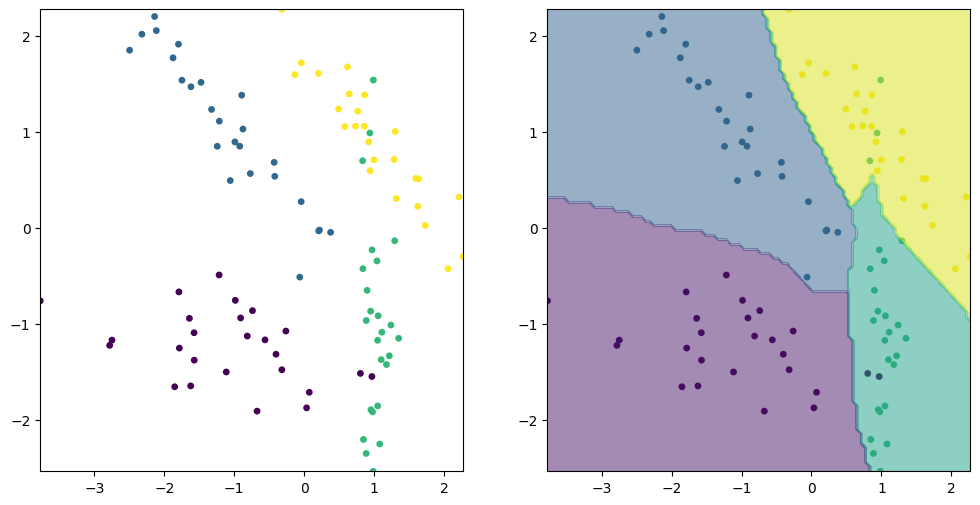

In [57]:
input_dim, output_dim = x.shape[1], y_onehot.shape[1]

# insira sua rede aqui!
nn = NeuralNetwork(cost_func=softmax_neg_log_likelihood, learning_rate=1e-1)

#BUILD
nn.layers.append(Layer(input_dim, 10, activation=relu))
nn.layers.append(Layer(10, output_dim, activation=linear))

#FIT
nn.fit(x, y_onehot, epochs=1000, verbose=1000)

#EVALUATION
y_pred = np.argmax(nn.predict(x), axis=1)

print('ACC: {:.2f}%'.format(100*accuracy_score(y, y_pred)))
plot.classification_predictions(x, y, is_binary=False, nn=nn)

### Iris Dataset

['sepal length (cm)', 'sepal width (cm)', 'petal length (cm)', 'petal width (cm)']
['setosa' 'versicolor' 'virginica']
(150, 2) (150, 1)


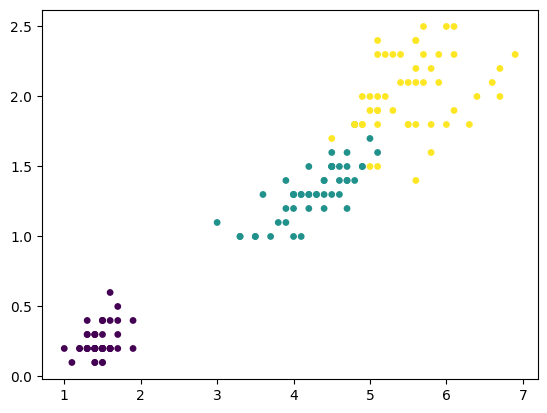

In [58]:
data = load_iris()
x, y = data.data[:, 2:], data.target.reshape(-1,1)

print(data.feature_names)
print(data.target_names)
print(x.shape, y.shape)
plt.scatter(x[:,0], x[:,1], c=list(np.array(y).ravel()), s=15, cmap=plt.cm.viridis)

In [59]:
onehot = OneHotEncoder(sparse=False)
y_onehot = onehot.fit_transform(y)
print(y_onehot[::20])

[[1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]]


/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Epoch:    0 / 3000 loss_train: 9.10282516
Epoch:  100 / 3000 loss_train: 0.70802687
Epoch:  200 / 3000 loss_train: 0.54812520
Epoch:  300 / 3000 loss_train: 0.47125229
Epoch:  400 / 3000 loss_train: 0.42181980
Epoch:  500 / 3000 loss_train: 0.38526702
Epoch:  600 / 3000 loss_train: 0.35610887
Epoch:  700 / 3000 loss_train: 0.33181873
Epoch:  800 / 3000 loss_train: 0.31103675
Epoch:  900 / 3000 loss_train: 0.29294367
Epoch: 1000 / 3000 loss_train: 0.27701090
Epoch: 1100 / 3000 loss_train: 0.26286469
Epoch: 1200 / 3000 loss_train: 0.25023100
Epoch: 1300 / 3000 loss_train: 0.23889199
Epoch: 1400 / 3000 loss_train: 0.22867167
Epoch: 1500 / 3000 loss_train: 0.21942533
Epoch: 1600 / 3000 loss_train: 0.21103169
Epoch: 1700 / 3000 loss_train: 0.20338796
Epoch: 1800 / 3000 loss_train: 0.19640629
Epoch: 1900 / 3000 loss_train: 0.19001116
Epoch: 2000 / 3000 loss_train: 0.18413731
Epoch: 2100 / 3000 loss_train: 0.17872814
Epoch: 2200 / 3000 loss_train: 0.17380493
Epoch: 2300 / 3000 loss_train: 0.1

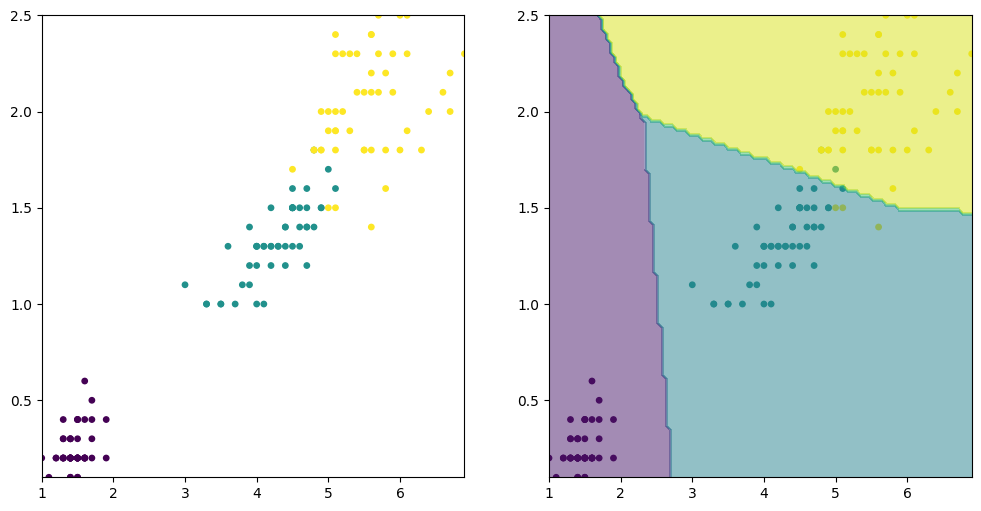

In [63]:
input_dim, output_dim = x.shape[1], y_onehot.shape[1]

# insira sua rede aqui!
nn = NeuralNetwork(cost_func=softmax_neg_log_likelihood, learning_rate=1e-2)

nn.layers.append(Layer(input_dim, 10, activation=relu))
nn.layers.append(Layer(10, output_dim, activation=linear))

nn.fit(x, y_onehot, epochs=3000, verbose=100)

y_pred = np.argmax(nn.predict(x), axis=1)

print('ACC: {:.2f}%'.format(100*accuracy_score(y, y_pred)))
plot.classification_predictions(x, y, is_binary=False, nn=nn)

# Referências

- [Tensorflow Playground](http://playground.tensorflow.org/#activation=tanh&batchSize=10&dataset=circle&regDataset=reg-plane&learningRate=0.03&regularizationRate=0&noise=0&networkShape=4,2&seed=0.94880&showTestData=false&discretize=false&percTrainData=50&x=true&y=true&xTimesY=false&xSquared=false&ySquared=false&cosX=false&sinX=false&cosY=false&sinY=false&collectStats=false&problem=classification&initZero=false&hideText=false)

- [Linear Classification](http://cs231n.github.io/linear-classify/)

__Regularization__:
- [Implementing Neural Network L1 Regularization](https://jamesmccaffrey.wordpress.com/2017/06/27/implementing-neural-network-l1-regularization/)
- [Implementing Neural Network L2 Regularization](https://jamesmccaffrey.wordpress.com/2017/06/29/implementing-neural-network-l2-regularization/)
- [Neural Network L2 Regularization Using Python](https://visualstudiomagazine.com/articles/2017/09/01/neural-network-l2.aspx)

__Momentum__:
- [Neural Network Momentum Using Python](https://visualstudiomagazine.com/articles/2017/08/01/neural-network-momentum.aspx)
- [Beyond SGD: Gradient Descent with Momentum and Adaptive Learning Rate](https://wiseodd.github.io/techblog/2016/06/22/nn-optimization/)

__Learning Rate Decay__:
- [Using Learning Rate Schedules for Deep Learning Models in Python with Keras](https://machinelearningmastery.com/using-learning-rate-schedules-deep-learning-models-python-keras/)
- [Learning Rate Schedules and Adaptive Learning Rate Methods for Deep Learning](https://towardsdatascience.com/learning-rate-schedules-and-adaptive-learning-rate-methods-for-deep-learning-2c8f433990d1)
- [Tensorflow Exponential Decay Documentation](https://www.tensorflow.org/api_docs/python/tf/train/exponential_decay)

__Batch Normalization__:
- [Understanding the backward pass through Batch Normalization Layer](https://kratzert.github.io/2016/02/12/understanding-the-gradient-flow-through-the-batch-normalization-layer.html)
- [Deriving the Gradient for the Backward Pass of Batch Normalization](https://kevinzakka.github.io/2016/09/14/batch_normalization/)
- [Implementing BatchNorm in Neural Net](https://wiseodd.github.io/techblog/2016/07/04/batchnorm/)
- [What does the gradient flowing through batch normalization looks like ?](http://cthorey.github.io./backpropagation/)
- [GRADIENTS, BATCH NORMALIZATION AND LAYER NORMALIZATION](https://theneuralperspective.com/2016/10/27/gradient-topics/)

__Gradient Checking__:
- [cs231n](https://github.com/cs231n/cs231n.github.io/blob/master/neural-networks-3.md#gradcheck)
- [Gradient checking and advanced optimization](http://ufldl.stanford.edu/wiki/index.php/Gradient_checking_and_advanced_optimization)
- [BatchNormalization fails gradient checking](https://github.com/torch/nn/issues/744)